# Import packages

In [50]:
import numpy as np
import pandas as pd
from itertools import chain
from pprint import pprint
from collections import Counter
from datetime import datetime

import sqlite3
from pathlib import Path

import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

In [8]:
#Topic modeling with LDA
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\U060419\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
path = Path('C:/Users/U060419/UCB/iPVU Web Scraping and trends - General/articles.db')

In [4]:
conn = sqlite3.connect('articles.db')
data = pd.read_sql("SELECT * FROM articles_unique",conn)
data.head()

,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
0,DOI:10.1016/j.ando.2020.04.005,10.1016/j.ando.2020.04.005,Annales d'Endocrinologie,2020-04-21 00:00:00+00:00,ELSEVIER,"['renin-angiotensin-aldosterone', 'system', 'c...",['Abstract With multiplication COVID-19 severe...,"['abstract', 'with', 'multiplication', 'covid-..."
1,DOI:10.1016/j.jamda.2020.04.017,10.1016/j.jamda.2020.04.017,Journal of the American Medical Directors Asso...,2020-04-23 00:00:00+00:00,ELSEVIER,"['the', 'geriatrician', 'the', 'frontline', 's...","['Abstract On February 20 , 2020 , man live no...","['abstract', 'on', 'february', '20', '2020', '..."
2,DOI:10.1016/j.fertnstert.2020.04.025,10.1016/j.fertnstert.2020.04.025,Fertility and Sterility,2020-04-16 00:00:00+00:00,ELSEVIER,"['prior', 'novel', 'coronaviruses', 'covid-19'...",['Structured Abstract Objective To summarize c...,"['structured', 'abstract', 'objective', 'to', ..."
3,DOI:10.1016/j.neurol.2020.04.004,10.1016/j.neurol.2020.04.004,Revue Neurologique,2020-04-20 00:00:00+00:00,ELSEVIER,"['guidance', 'care', 'neuromuscular', 'patient...","['Abstract In France , epidemic phase COVID-19...","['abstract', 'in', 'france', 'epidemic', 'phas..."
4,DOI:10.1016/j.jtcvs.2020.04.059,10.1016/j.jtcvs.2020.04.059,The Journal of Thoracic and Cardiovascular Sur...,2020-04-27 00:00:00+00:00,ELSEVIER,"['adult', 'cardiac', 'surgery', 'covid-19', 'p...",['Abstract The COVID-19 pandemic necessitate a...,"['abstract', 'the', 'covid-19', 'pandemic', 'n..."


# Visualizations

## Number of publications per source

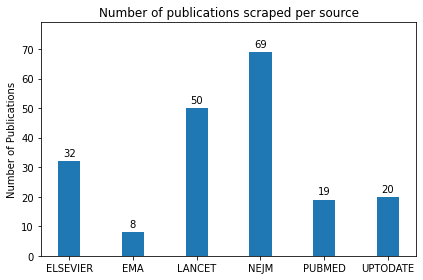

In [5]:
# TO DO - rewrite query for mydate
mydata = data.groupby(['Source']).count()
sources = mydata.index
counts = mydata.title_words

x = np.arange(len(sources))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, counts, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Publications')
ax.set_title('Number of publications scraped per source')
ax.set_xticks(x)
ax.set_xticklabels(sources)
ax.set_ylim([0, max(counts)+10])
# ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

fig.tight_layout()

plt.show()

## Wordcloud per publication

In [12]:
# TO DO: further finetune stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 
                   'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 
                   'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 
                   'may', 'take', 'come',
                   'abstract','structured','introduction','google','scholar','pubmed'])

In [23]:
# TO DO: rewrite query + include title (or include title if publication is missing)
data_processed = data[['ID','PublishedDate','abstract_words']]
print('Number of missing values in publishedDate and/or abstract:\n'+str(data_processed.isna().sum()))
# data_ready_with_publicationDate.dropna(inplace=True)

import ast
def process_words(text, stop_words=stop_words):
    """Remove Stopwords"""
    text_out = []
    for word in ast.literal_eval(text):
        if word not in stop_words: 
            text_out.append(word)
    return text_out

data_processed['abstract_words'] = data_processed['abstract_words'].apply(lambda abstract: process_words(abstract))  # processed Text Data!

Number of missing values in publishedDate and/or abstract:
ID                 1
PublishedDate     55
abstract_words     0
dtype: int64


c:\python_3.7.4\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


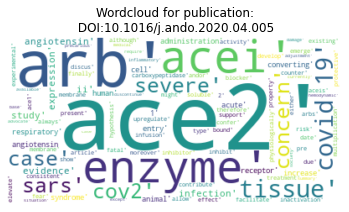

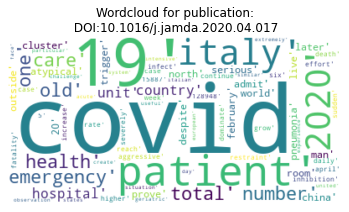

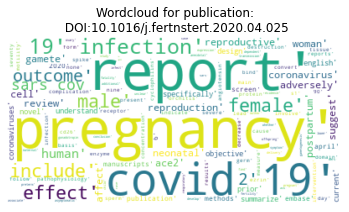

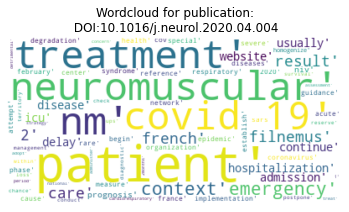

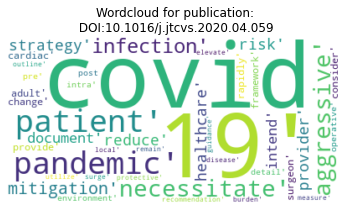

In [84]:
#TO DO: extract title instead of ID
#First 5 publications

for ID in data_processed[0:5]['ID']:
    publ = data_processed[data_processed['ID'] == ID]
    text = ' '.join([str(word) for word in publ['abstract_words']]) 

    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Wordcloud for publication:\n'+publ['ID'].to_string(index=False))
    plt.axis("off")
    plt.show()

## Keyword count for top 5 per publication (bar chart)

In [54]:
def try_parsing_date(text):
    if text == None:
        return None
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S+00:00', '%Y-%m-%d'):
        try:
            return datetime.strptime(text, fmt).date()
        except ValueError:
            pass
    raise ValueError('no valid date format found')

data_processed['PublishedDate'] = data_processed['PublishedDate'].apply(lambda x: try_parsing_date(x))

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [56]:
#load keywords
file = open("Data/keywords_ipvu.txt","r")
keywords = file.read().strip()
keywords = keywords.split(',')
print(keywords)
print(type(keywords))
file.close()

['certolizumab', 'pegol', 'brodalumab', 'kyntheum', 'ixekizumab', 'taltz', 'secukinumab', 'cosentyx', 'ustekinumab', 'stelara', 'guselkumab', 'tremfya', 'risankizumab', 'skyrizi', 'tildrakizumab', 'ilumetri', 'tocilizumab', 'roactemra', 'tofacitinib', 'rituximab', 'olimumab', 'xeljanz', 'mabthera', 'simponi', 'baracitinib\t', 'adalimumab', 'baricitinib', 'olumiant', 'humira', 'olumiant', 'apremilast', 'etanercept', 'upadacitinib', 'otezla', 'enbrel', 'rinvoq', 'abatacept', 'infliximab', 'certolizumab pegol', 'orencia', 'remicade', 'cimzia', 'methotrexate', 'mycophenolate mofetil', 'azathioprine', 'cyclophosphamide', 'chloroquine', 'tacrolimus', 'ciclosporin', 'global health emergency', 'hydroxychloroquine', 'leflunomide', 'infection', 'sulfasalazine', 'SARS-CoV-2', 'in vitro', 'safety', 'psoriasis']
<class 'list'>


In [57]:
data_with_keyword = data_processed
for keyword in keywords:
    data_with_keyword[keyword] = data_with_keyword['abstract_words'].apply(lambda x: x.count(keyword) if (keyword in x) 
                                                                           else 0)
    
data_with_keyword = data_with_keyword.groupby(['ID'],as_index=True).sum()
print(data_with_keyword)

                                                    certolizumab  pegol  \
ID                                                                        
DOI:10.1007/s11547-020-01200-3                                 0      0   
DOI:10.1016/S0140-6736(14)61202-2                              0      0   
DOI:10.1016/S0140-6736(20)30183-5                              0      0   
DOI:10.1016/S0140-6736(20)30460-8                              0      0   
DOI:10.1016/S0140-6736(20)30566-3                              0      0   
...                                                          ...    ...   
URL:emas-governance-during-covid-19-pandemic                   0      0   
URL:guidance-medicine-developers-companies-covi...             0      0   
URL:international-coalition-medicines-regulator...             0      0   
URL:public-health-advice-during-covid-19-pandemic              0      0   
URL:treatments-vaccines-covid-19                               0      0   

                        

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


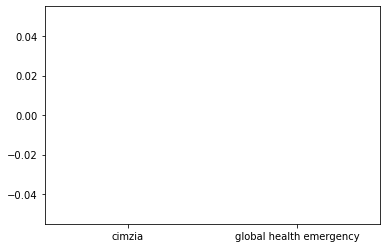

In [83]:
#First 5 publications

for ID in data_with_keyword[0:5].index:
    publ = data_with_keyword[data_with_keyword.index == ID]
    #TO DO: select top 5 keywords
    top_5 = publ[['cimzia','global health emergency']]
    plt.bar(top_5.columns, top_5.iloc[0,:], align='center')

In [82]:
top_5.iloc[0,:]

cimzia                     0
global health emergency    0
Name: DOI:10.1016/S0140-6736(20)30566-3, dtype: int64